True MAP Classification Error ≈ 0.0175

=== Training Size: 100 ===
Selected Optimal Hidden Units (P): 64
Test Error = 0.0244

=== Training Size: 500 ===
Selected Optimal Hidden Units (P): 64
Test Error = 0.0215

=== Training Size: 1000 ===
Selected Optimal Hidden Units (P): 64
Test Error = 0.0232

=== Training Size: 5000 ===
Selected Optimal Hidden Units (P): 64
Test Error = 0.0202

=== Training Size: 10000 ===
Selected Optimal Hidden Units (P): 64
Test Error = 0.0302


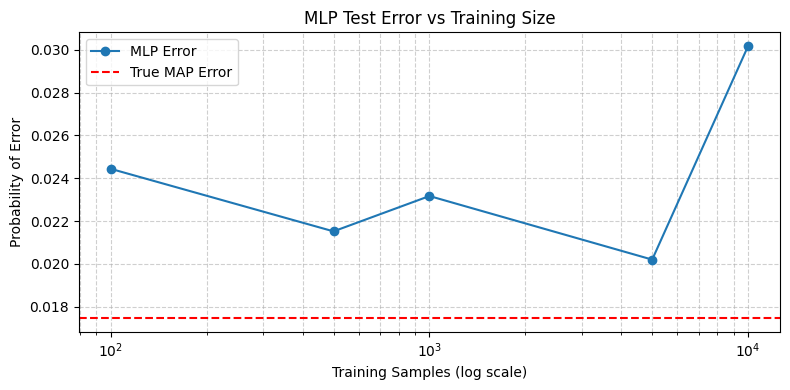

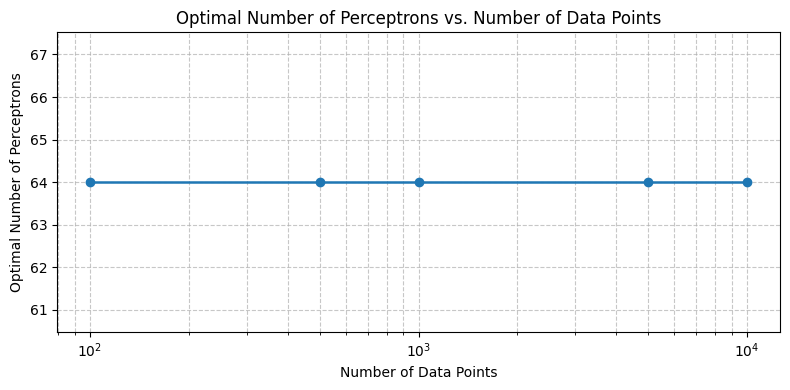


===== Summary =====
Training Size | Optimal P | Test Error
100            | 64         | 0.0244
500            | 64         | 0.0215
1000           | 64         | 0.0232
5000           | 64         | 0.0202
10000          | 64         | 0.0302


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from tqdm import tqdm
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# ---------------------------
# Reproducibility
# ---------------------------
torch.manual_seed(0)
np.random.seed(0)

# ---------------------------
# 1. Define 4 Gaussian classes in 3D
# ---------------------------
means = [
    np.array([0, 0, 0]),
    np.array([3, 3, 3]),
    np.array([-3, 3, -3]),
    np.array([3, -3, -3])
]

covs = [
    np.diag([2, 1, 1]),
    np.diag([1, 2, 1]),
    np.diag([1, 1, 2]),
    np.diag([1.5, 1.5, 1.5])
]

priors = [0.25] * 4
C = 4  # classes
d = 3  # dimensions

# ---------------------------
# 2. Generate Gaussian Data
# ---------------------------
def generate_gaussian_data(N):
    X, y = [], []
    samples_per_class = N // C
    for i in range(C):
        Xi = np.random.multivariate_normal(means[i], covs[i], samples_per_class)
        yi = np.full(samples_per_class, i)
        X.append(Xi)
        y.append(yi)
    return np.vstack(X), np.hstack(y)

# ---------------------------
# 3. True MAP Classifier
# ---------------------------
def map_predict(X):
    log_probs = np.zeros((X.shape[0], C))
    for i in range(C):
        log_probs[:, i] = multivariate_normal.logpdf(X, means[i], covs[i]) + np.log(priors[i])
    return np.argmax(log_probs, axis=1)

def compute_error(y_true, y_pred):
    return np.mean(y_true != y_pred)

# ---------------------------
# 4. MLP Model Definition
# ---------------------------
class MLP(nn.Module):
    def __init__(self, P):
        super().__init__()
        self.hidden = nn.Linear(d, P)
        self.act = nn.ELU()
        self.output = nn.Linear(P, C)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(self.output(self.act(self.hidden(x))))

# ---------------------------
# 5. Train MLP with multiple restarts
# ---------------------------
def train_mlp(X_train, y_train, P, restarts=3, epochs=200, lr=1e-3):
    best_model = None
    best_loss = float('inf')

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    criterion = nn.CrossEntropyLoss()

    for _ in range(restarts):
        torch.manual_seed(np.random.randint(0, 10000))  # new init per restart
        model = MLP(P)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for _ in range(epochs):
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = model

    return best_model

# ---------------------------
# 6. Cross-Validation for Model Order Selection
# ---------------------------
def cross_validate_hidden_units(X, y, P_values, folds=10):
    best_P = None
    best_acc = -1

    kf = KFold(n_splits=folds, shuffle=True)
    for P in P_values:
        accs = []
        for train_idx, val_idx in kf.split(X):
            # Random seed per fold for diversity
            torch.manual_seed(np.random.randint(0, 10000))
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = train_mlp(X_train, y_train, P, epochs=200, restarts=2)
            with torch.no_grad():
                pred = torch.argmax(model(torch.tensor(X_val, dtype=torch.float32)), dim=1)
                acc = np.mean(pred.numpy() == y_val)
                accs.append(acc)

        avg_acc = np.mean(accs)
        # Small jitter to break ties
        avg_acc += np.random.normal(0, 0.0005)

        if avg_acc > best_acc:
            best_acc = avg_acc
            best_P = P

    return best_P

# ---------------------------
# 7. Main Experiment Loop
# ---------------------------
train_sizes = [100, 500, 1000, 5000, 10000]
P_candidates = [4, 8, 16, 32, 64]

mlp_errors = []
optimal_Ps = []

# Large fixed test set for fair evaluation
X_test, y_test = generate_gaussian_data(100000)
map_test_pred = map_predict(X_test)
map_error = compute_error(y_test, map_test_pred)
print(f"True MAP Classification Error ≈ {map_error:.4f}")

for N in train_sizes:
    print(f"\n=== Training Size: {N} ===")
    X, y = generate_gaussian_data(N)

    best_P = cross_validate_hidden_units(X, y, P_candidates)
    optimal_Ps.append(best_P)

    print(f"Selected Optimal Hidden Units (P): {best_P}")

    model = train_mlp(X, y, P=best_P)
    with torch.no_grad():
        pred = torch.argmax(model(torch.tensor(X_test, dtype=torch.float32)), dim=1).numpy()

    mlp_error = compute_error(y_test, pred)
    mlp_errors.append(mlp_error)
    print(f"Test Error = {mlp_error:.4f}")

# ---------------------------
# 8. Plot: MLP vs MAP Error
# ---------------------------
plt.figure(figsize=(8,4))
plt.semilogx(train_sizes, mlp_errors, marker='o', label="MLP Error")
plt.axhline(map_error, linestyle='--', color='r', label="True MAP Error")
plt.xlabel("Training Samples (log scale)")
plt.ylabel("Probability of Error")
plt.title("MLP Test Error vs Training Size")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------
# 9. Plot: Optimal P vs Data Size
# ---------------------------
plt.figure(figsize=(8,4))
plt.semilogx(train_sizes, optimal_Ps, marker='o', linewidth=1.8)
plt.title('Optimal Number of Perceptrons vs. Number of Data Points')
plt.xlabel('Number of Data Points')
plt.ylabel('Optimal Number of Perceptrons')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ---------------------------
# 10. Print Summary Table
# ---------------------------
print("\n===== Summary =====")
print("Training Size | Optimal P | Test Error")
for N, P, e in zip(train_sizes, optimal_Ps, mlp_errors):
    print(f"{N:<14} | {P:<10} | {e:.4f}")


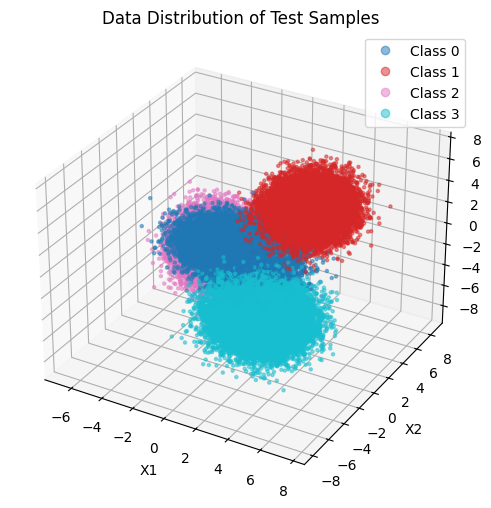

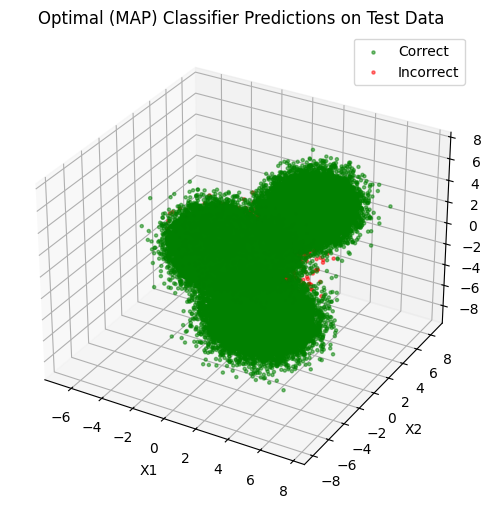

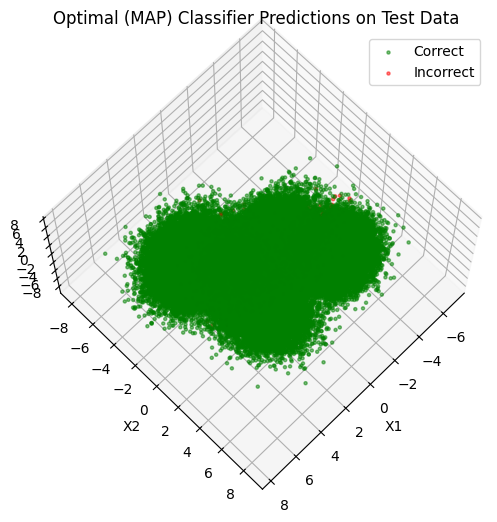

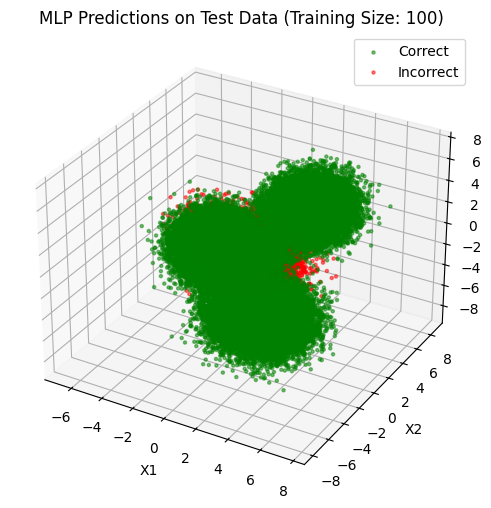

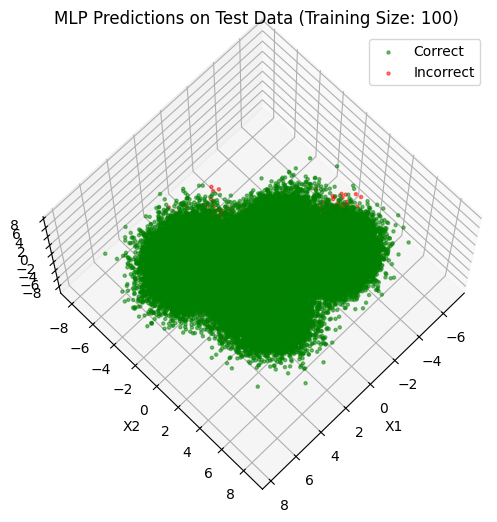

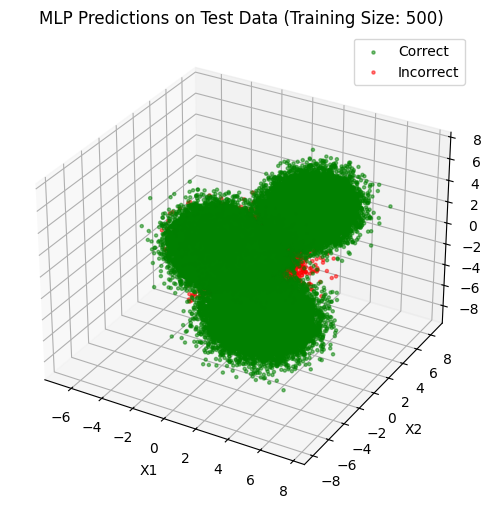

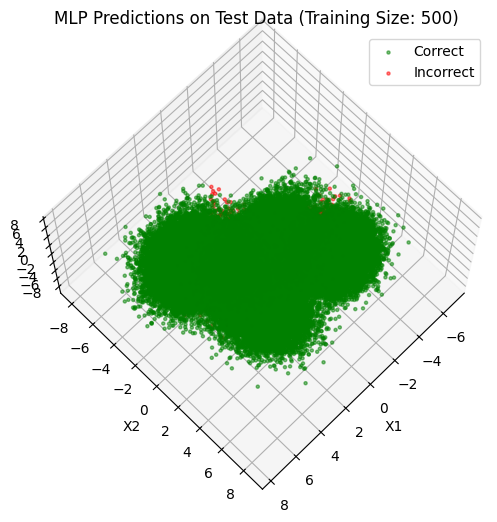

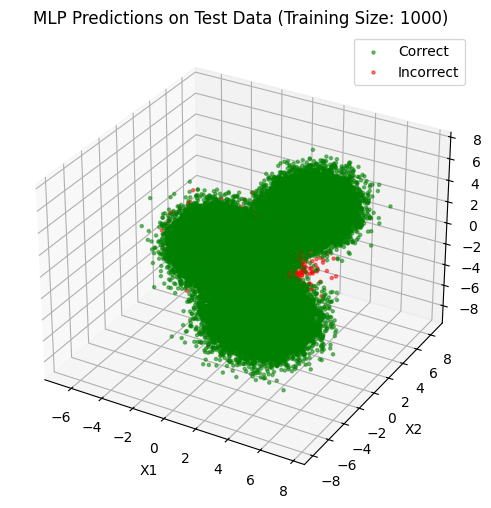

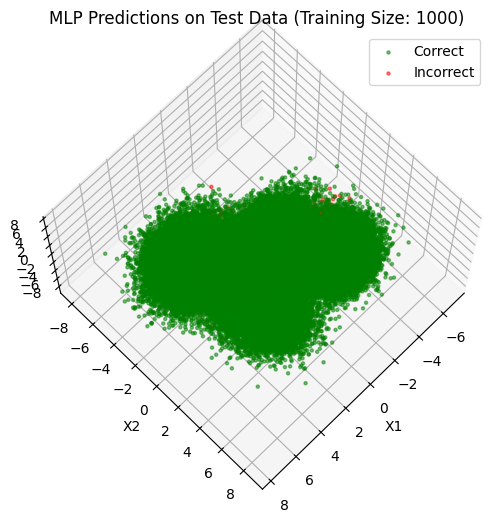

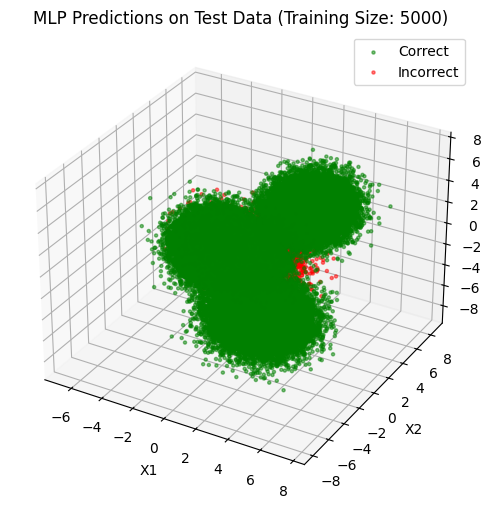

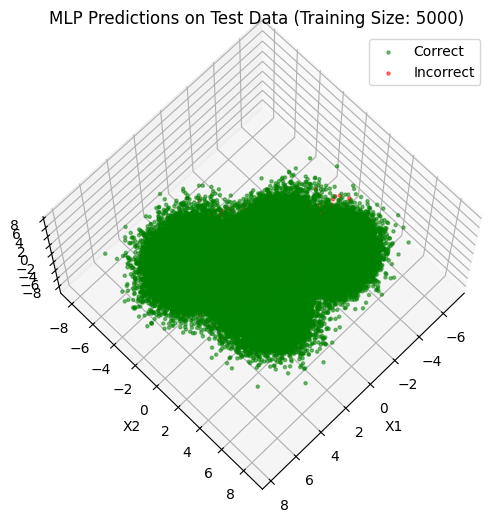

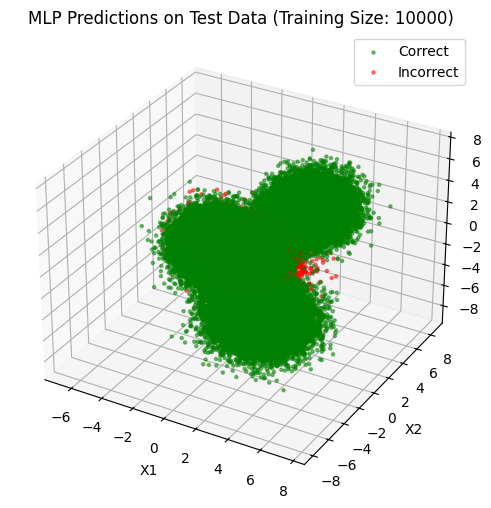

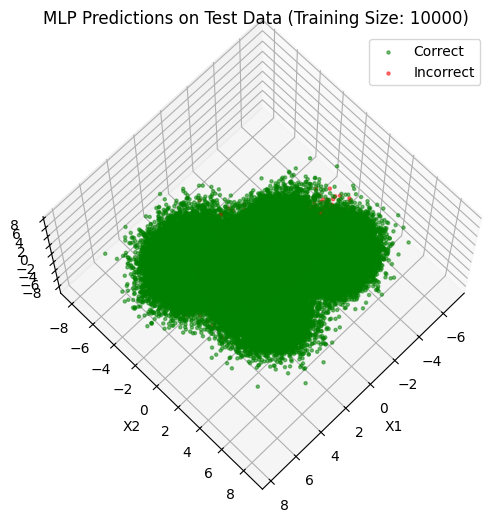

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_true_distribution(X, y_true):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:,0], X[:,1], X[:,2], c=y_true, cmap='tab10', s=5, alpha=0.5)
    ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.set_zlabel('X3')
    ax.set_title('Data Distribution of Test Samples')
    handles, labels = scatter.legend_elements()
    plt.legend(handles, [f'Class {i}' for i in range(C)], loc='upper right')
    plt.show()

def plot_predictions(X, y_true, y_pred, title):
    correct_mask = y_true == y_pred
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[correct_mask,0], X[correct_mask,1], X[correct_mask,2],
               color='green', s=5, alpha=0.5, label='Correct')
    ax.scatter(X[~correct_mask,0], X[~correct_mask,1], X[~correct_mask,2],
               color='red', s=5, alpha=0.5, label='Incorrect')
    ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.set_zlabel('X3')
    ax.set_title(title)
    ax.legend()
    plt.show()

    # second view angle for depth perception
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[correct_mask,0], X[correct_mask,1], X[correct_mask,2],
               color='green', s=5, alpha=0.5, label='Correct')
    ax.scatter(X[~correct_mask,0], X[~correct_mask,1], X[~correct_mask,2],
               color='red', s=5, alpha=0.5, label='Incorrect')
    ax.view_init(elev=70, azim=45)
    ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.set_zlabel('X3')
    ax.set_title(title)
    ax.legend()
    plt.show()
# (a) True test data
plot_true_distribution(X_test, y_test)

# (b) MAP classifier results
plot_predictions(X_test, y_test, map_test_pred, "Optimal (MAP) Classifier Predictions on Test Data")

# (c) MLP predictions for each training size
for N, Popt in zip(train_sizes, optimal_Ps):
    X_train, y_train = generate_gaussian_data(N)
    model = train_mlp(X_train, y_train, Popt)
    with torch.no_grad():
        y_pred = torch.argmax(model(torch.tensor(X_test, dtype=torch.float32)), dim=1).numpy()
    title = f"MLP Predictions on Test Data (Training Size: {N})"
    plot_predictions(X_test, y_test, y_pred, title)



Finished all repetitions.

=== Results for N = 10 ===
 K  Count  Percentage
 1     96        96.0
 2      3         3.0
 3      1         1.0
 4      0         0.0
 5      0         0.0
 6      0         0.0
 7      0         0.0
 8      0         0.0
 9      0         0.0
10      0         0.0

=== Results for N = 100 ===
 K  Count  Percentage
 1      0         0.0
 2     48        48.0
 3     25        25.0
 4     20        20.0
 5      7         7.0
 6      0         0.0
 7      0         0.0
 8      0         0.0
 9      0         0.0
10      0         0.0

=== Results for N = 1000 ===
 K  Count  Percentage
 1      0         0.0
 2      0         0.0
 3      0         0.0
 4     65        65.0
 5     16        16.0
 6     10        10.0
 7      4         4.0
 8      3         3.0
 9      2         2.0
10      0         0.0


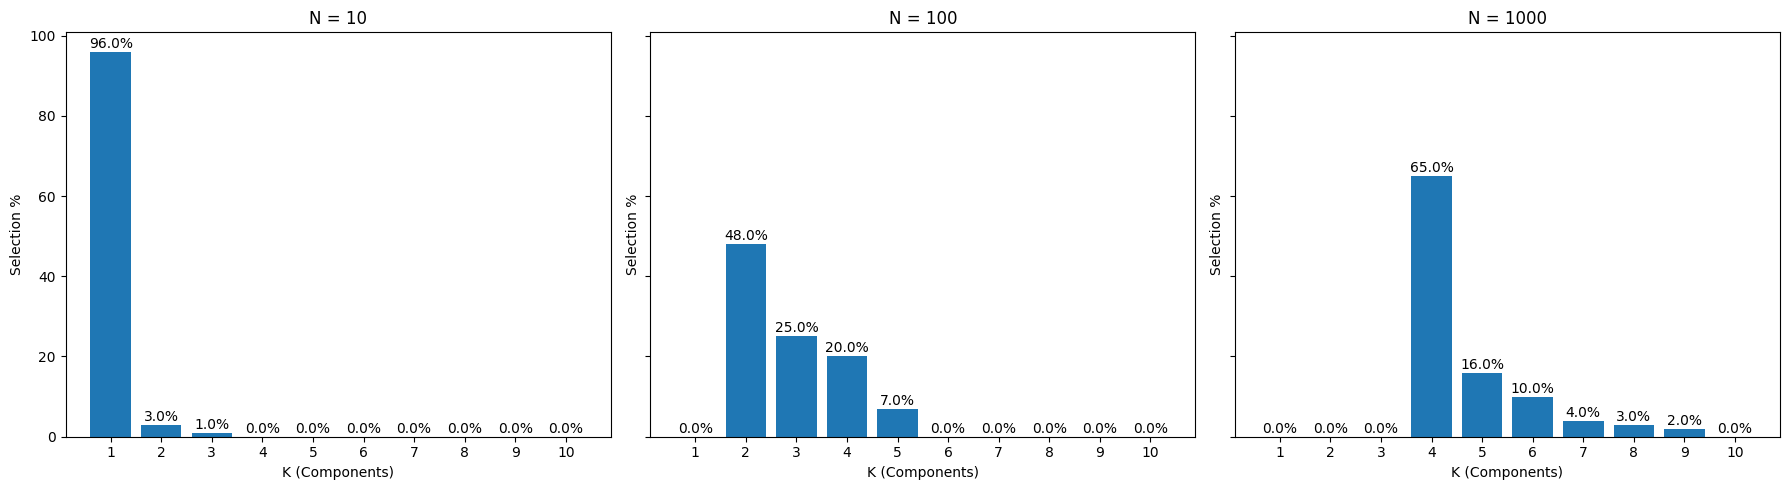

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ============================================
# 0. GLOBAL SETTINGS
# ============================================
np.random.seed(42)

# Reduce EM complexity while staying rigorous
GMM_INIT = 2        # was 1 → stable but fast
GMM_ITER = 150      # was high → reduced for speed
FOLDS = 10
REPEATS = 100
MAX_COMPONENTS = 10

# ============================================
# 1. TRUE GMM (YOUR PARAMETERS + FIX FOR OVERLAP)
# ============================================
def create_true_gmm():
    means = np.array([
        [0, 0],
        [1.5, 1.2],    # closer → **strong overlap**
        [5, 0],
        [3, 3]
    ])

    covariances = np.array([
        [[1.0, 0.8], [0.8, 1.0]],    # rotated → overlap
        [[1.0, -0.6], [-0.6, 1.0]],  # rotated differently → overlap
        [[0.5, 0], [0, 0.5]],
        [[0.5, 0], [0, 0.5]]
    ])

    weights = np.array([0.4, 0.4, 0.1, 0.1])
    return means, covariances, weights

# ============================================
# 2. DATA GENERATION
# ============================================
def generate_dataset(n_samples, means, covariances, weights):
    k = len(weights)
    X = []
    component_sizes = np.random.multinomial(n_samples, weights)

    for i in range(k):
        if component_sizes[i] > 0:
            Xi = np.random.multivariate_normal(
                mean=means[i],
                cov=covariances[i],
                size=component_sizes[i]
            )
            X.append(Xi)

    X = np.vstack(X)

    # Shuffle
    np.random.shuffle(X)
    return X

# ============================================
# 3. CROSS-VALIDATION FOR MODEL ORDER SELECTION
# ============================================
def cross_validate_gmm(X, max_components=10, n_splits=10):
    """
    Returns:
        best_K, avg_loglikes[K]
    """
    n = len(X)

    # Adjust folds for tiny datasets
    n_splits = min(n_splits, n)
    kf = KFold(n_splits=n_splits, shuffle=True)

    avg_ll = np.full(max_components, -np.inf)

    for K in range(1, max_components + 1):
        fold_ll = []
        valid = True

        for train_idx, val_idx in kf.split(X):
            Xtr, Xval = X[train_idx], X[val_idx]

            # Cannot fit more components than training samples
            if len(Xtr) < K:
                valid = False
                break

            try:
                gmm = GaussianMixture(
                    n_components=K,
                    covariance_type='full',
                    n_init=GMM_INIT,
                    max_iter=GMM_ITER,
                    reg_covar=1e-6,
                    random_state=np.random.randint(10000)
                ).fit(Xtr)

                ll = gmm.score(Xval)  # average log-likelihood
                fold_ll.append(ll)

            except:
                fold_ll.append(-np.inf)

        if valid and len(fold_ll) > 0:
            avg_ll[K-1] = np.mean(fold_ll)

    # Best K = highest log-likelihood
    best_K = np.argmax(avg_ll) + 1
    return best_K, avg_ll

# ============================================
# 4. RUN FULL EXPERIMENT
# ============================================
def run_experiment(n_samples_list, repeats=100, max_components=10):
    selection_counts = {N: [] for N in n_samples_list}

    for r in range(repeats):
        print(f"Running repetition {r+1}/{repeats}...", end="\r")
        means, covs, weights = create_true_gmm()

        for N in n_samples_list:
            X = generate_dataset(N, means, covs, weights)
            best_K, _ = cross_validate_gmm(
                X,
                max_components=max_components,
                n_splits=FOLDS
            )
            selection_counts[N].append(best_K)

    print("\nFinished all repetitions.")
    return selection_counts

# ============================================
# 5. SUMMARIZE INTO TABLES
# ============================================
def summarize_results(selection_counts, max_components=10):
    tables = {}
    for N, selections in selection_counts.items():
        counts = Counter(selections)
        total = sum(counts.values())

        rows = []
        for K in range(1, max_components+1):
            c = counts.get(K, 0)
            pct = 100 * c / total
            rows.append({"K": K, "Count": c, "Percentage": pct})

        tables[N] = pd.DataFrame(rows)
    return tables

# ============================================
# 6. PLOT RESULTS
# ============================================
def plot_results(tables):
    fig, axs = plt.subplots(1, len(tables), figsize=(18, 5), sharey=True)

    for ax, (N, df) in zip(axs, tables.items()):
        ax.bar(df["K"], df["Percentage"])
        ax.set_title(f"N = {N}")
        ax.set_xlabel("K (Components)")
        ax.set_ylabel("Selection %")
        ax.set_xticks(range(1, MAX_COMPONENTS+1))
        for _, row in df.iterrows():
            ax.text(row["K"], row["Percentage"]+1, f"{row['Percentage']:.1f}%", ha="center")

    plt.tight_layout()
    plt.show()

# ============================================
# MAIN
# ============================================
if __name__ == "__main__":
    n_samples_list = [10, 100, 1000]

    selection_counts = run_experiment(
        n_samples_list,
        repeats=REPEATS,
        max_components=MAX_COMPONENTS
    )

    tables = summarize_results(selection_counts, max_components=MAX_COMPONENTS)

    for N, df in tables.items():
        print(f"\n=== Results for N = {N} ===")
        print(df.to_string(index=False))

    plot_results(tables)
